## 5.1 Installation and Setup (Colab)

In [ ]:
!git clone https://github.com/opendp/smartnoise-sdk

Check smartnoise-sdk is downloaded

In [ ]:
!ls

sample_data  smartnoise-sdk


Go into the folder that setup.py located

In [1]:
cd smartnoise-sdk/synth

/home/ec2-user/SageMaker/smartnoise-sdk/synth


In [2]:
!ls

build  HISTORY.md      README.md  smartnoise_synth.egg-info  VERSION
dist   Makefile        samples	  snsynth
docs   pyproject.toml  setup.py   tests


In [ ]:
!python setup.py build

In [ ]:
!python setup.py install

***Note: If you need to install the related packages below, after running "pip" you should restart runtime (in Colab environment). Only after restarting the runtime can the Colab succesfully has the packages loaded in the environemnt and then you are able to run the following cells.***

In [3]:
!pip install diffprivlib 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install opacus

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install threadpoolctl

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip install ctgan==0.4.3

     |████████████████████████████████| 9.5 MB 28.1 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Now we are able to import the synthesizer. Also, due to the previous `cd smartnoise-sdk/synth` command, our jupyter notebook is inside smartnoise-sdk/synth so importing `snsynth` shall not run into any problem!

In [1]:
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from diffprivlib.models import LogisticRegression as DPLR
from sklearn.metrics import classification_report
from snsynth.mwem import MWEMSynthesizer

import warnings
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN
from snsynth.pytorch.nn import PATECTGAN
warnings.filterwarnings("ignore")

/Users/wenlingong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def process_COMPAS(temp_df, is_GAN = False):
    """
    Pick columns = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 
    'juv_other_count', 'length_of_stay','race','two_year_recid', 'c_charge_degree'] 
    from the dataframe. Convert category data into numeric and remove races other 
    than Caucasian or African-American. 
    
    Input: COMPAS dataframe
    Output: 
           COMPAS dataframe after cleaning
            age_cat                    int64
            priors_count               int64
            sex_numeric                int64
            juv_fel_count              int64
            juv_misd_count             int64
            juv_other_count            int64
            c_charge_degree_numeric    int64
            length_of_stay             int64
            race                       int64
            two_year_recid             int64
    """
    # deepcopy
    df = temp_df.copy()
    
    # remove invalid/null entries
    df = df[(df['days_b_screening_arrest'] <= 30)
                & (df['days_b_screening_arrest'] >= -30)
                & (df['is_recid'] != -1)
                & (df['c_charge_degree'] != 'O')
                & (df['score_text'] != 'N/A')]
    # remove races other than Caucasian or African-American
    df = df[(df['race']=='Caucasian') | (df['race']=='African-American')]

    # calculate length_of_stay
    df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
    # the number of seconds to the unix epoch start
    df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).astype(int) / 10**9 
    # convert seconds into month
    df['length_of_stay'] /= 60 * 60 * 24 * 31
    df['length_of_stay'] = df['length_of_stay'].astype(int)
    df = df.drop_duplicates()

    # convert category data into numeric
    df['sex_numeric'] = pd.factorize(df['sex'])[0]
    df['c_charge_degree_numeric'] = pd.factorize(df['c_charge_degree'])[0]
    race = {0: 'Caucasian', 1: 'African-American'}
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    if is_GAN:
      # don't need to bin age
      df["age_cat"] = df["age"]
    else:
      age = {1: 'Greater than 45', 0: '25 - 45', -1: 'Less than 25'}
      df["age_cat"] = df["age_cat"].map({v: k for k, v in age.items()})

    cols = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree_numeric', 'length_of_stay','race','two_year_recid']
    df = df[cols]
    
    return df

In [3]:
def logisticRegression(x_train, y_train, x_test):
    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=500)
    logisticRegr.fit(x_train, y_train)

    train_predictions = logisticRegr.predict(x_train)
    test_predictions = logisticRegr.predict(x_test)
    return train_predictions, test_predictions

In [4]:
def predictionSummary(temp_x, y_real, y_predict, df):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict, labels=[0, 1]).ravel()
    # False Positive, False Negative, True Positive, True Negative, Overall Accuracy
    overall = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/y_real.shape[0]]

    x = temp_x.copy()
    x['medium_or_high_risk'] = y_predict
    x['two_year_recid'] = y_real
    
    # African-American
    x_black = x[df['race']==1].copy()
    tn, fp, fn, tp = confusion_matrix(x_black['two_year_recid'], x_black['medium_or_high_risk'], labels=[0, 1]).ravel()
    black = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    # Caucasian
    x_white = x[df['race']==0].copy()
    tn, fp, fn, tp = confusion_matrix(x_white['two_year_recid'], x_white['medium_or_high_risk'], labels=[0, 1]).ravel()
    white = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    return overall, black, white

In [5]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    def QuailSynth(epsilon):
      return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
    
    # Instantiate a DPLR classifier
    def QuailClassifier(epsilon):
      return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split) ## none for classifier

    return quail

In [84]:
def synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM", all_results = False):
    test_results, train_results = [],[]
    if all_results: 
        test_all_results, test_synth_all_results, train_all_results = [],[],[]
    recid_ratio, race_ratio, recid_ratio_avg, race_ratio_avg = [],[],[],[]
    table, table00, table01, table10, table11 = [], [], [], [], []
    # Loop through range of epsilon values
    for epsilon in epsilons:
        print(str(epsilon)+": ", end="")
        train_overall, train_black, train_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        test_overall, test_black, test_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        
        recid_ratio.append([])
        race_ratio.append([])
        table.append([])
    
        # Generate synthetic data many times (to average results)
        for i in range(niteration):
            print(str(i), end=", ")
            while True:
              # Generate synthetic training data
              if synthesizer == "MWEM":
                  synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15,
                                        splits=[], split_factor=6, max_bin_count=400) 
                  # learn the distribution of the real data
                  fit = synth.fit(train_data.to_numpy())  
              if synthesizer == "QUAIL":
                  synth = get_quail_synthesizer("DPLR", None, epsilon, None, target="two_year_recid")
                  fit = synth.fit(train_data)  
              if synthesizer == "DPCTGAN":
                  synth = PytorchDPSynthesizer(epsilon, DPCTGAN(), None)
                  fit = synth.fit(train_data, ['race','sex_numeric','c_charge_degree_numeric','c_charge_degree_numeric','two_year_recid'])
              if synthesizer == "PATECTGAN":
                  synth = PytorchDPSynthesizer(epsilon, PATECTGAN(regularization='dragan'), None)
                  fit = synth.fit(train_data, ['race','sex_numeric','c_charge_degree_numeric','c_charge_degree_numeric','two_year_recid'])

              if not all_results:
                  # generate synthetic train data
                  train_synth = pd.DataFrame(synth.sample(train_data.shape[0]), columns=train_data.columns) 
                  # Split synthetic training data into X and y
                  x_train, y_train = train_synth.drop(["two_year_recid","race"], axis=1), train_synth["two_year_recid"]
              else: 
                  synth_data = pd.DataFrame(synth.sample(train_data.shape[0] + test_data.shape[0]), columns=train_data.columns)
                  train_synth, test_synth = synth_data[:train_data.shape[0]], synth_data[train_data.shape[0]:]
                  x_train, y_train = train_synth.drop(["two_year_recid","race"], axis=1), train_synth["two_year_recid"]
                  x_test_synth, y_test_synth = test_synth.drop(["two_year_recid","race"], axis=1), test_synth["two_year_recid"]
                   
              if len(np.unique(y_train)) == 2:
                break
              else:
                print(np.unique(y_train, return_counts=True))

            # Run the binary classification pipeline
            y_train_predict, y_test_predict = logisticRegression(x_train, y_train, x_test)
            # Save results for each i and for each epsilon
            curr_train_overall, curr_train_black, curr_train_white = predictionSummary(x_train, y_train, y_train_predict, train_synth)
            curr_test_overall, curr_test_black, curr_test_white = predictionSummary(x_test, y_test, y_test_predict, test_data)
            
            if all_results:
                _, y_test_synth_predict = logisticRegression(x_train, y_train, x_test_synth)
                curr_test_synth_overall, curr_test_synth_black, curr_test_synth_white = predictionSummary(x_test_synth, y_test_synth, y_test_synth_predict, test_synth)
            
            train_overall = [rate1+rate2 for rate1,rate2 in zip(train_overall,curr_train_overall)]
            train_white = [rate1+rate2 for rate1,rate2 in zip(train_white,curr_train_white)]
            train_black = [rate1+rate2 for rate1,rate2 in zip(train_black,curr_train_black)]
            test_overall = [rate1+rate2 for rate1,rate2 in zip(test_overall,curr_test_overall)]
            test_white = [rate1+rate2 for rate1,rate2 in zip(test_white,curr_test_white)]
            test_black = [rate1+rate2 for rate1,rate2 in zip(test_black,curr_test_black)]
            
            if all_results:
                if i == 0:
                    test_all_results.append([])
                    test_synth_all_results.append([]) 
                    train_all_results.append([])
                test_all_results[-1].append([curr_test_overall, curr_test_black, curr_test_white])
                test_synth_all_results[-1].append([curr_test_synth_overall, curr_test_synth_black, curr_test_synth_white])
                train_all_results[-1].append([curr_train_overall, curr_train_black, curr_train_white])
            
            # calcualte recidivism ratio and race ratio
            recid_ratio[-1].append( (train_synth['two_year_recid']==1).sum()/train_synth.shape[0] )
            race_ratio[-1].append( (train_synth['race']==1).sum()/train_synth.shape[0] )
            
            # calculate white, not recidivate [0][0] & white recidivate [0][1]
            #           black, not recidivate [1][0] & black recidivat  [1][1] ratio
            cm = pd.crosstab(train_synth['race'], train_synth['two_year_recid'], rownames=['Race'], colnames=['Two Year Recid'])
            cm = round(cm/(train_synth.shape[0]),5)
            table[-1].append(cm)
        
        print()
        train_overall = [rate/niteration for rate in train_overall]
        train_black = [rate/niteration for rate in train_black]
        train_white = [rate/niteration for rate in train_white]
        train_results.append([train_overall,train_black,train_white])
        test_overall = [rate/niteration for rate in test_overall]
        test_black = [rate/niteration for rate in test_black]
        test_white = [rate/niteration for rate in test_white]
        test_results.append([test_overall,test_black,test_white])
        
        recid_ratio_avg.append(sum(recid_ratio[-1])/niteration)
        race_ratio_avg.append(sum(race_ratio[-1])/niteration) 
        table00.append( sum([t[0][0] for t in table[-1]]) /niteration)
        table01.append( sum([t[0][1] for t in table[-1]] ) /niteration)
        table10.append( sum([t[1][0] for t in table[-1]] ) /niteration)
        table11.append( sum([t[1][1] for t in table[-1]] ) /niteration)
    
    ratio_results = {"recid_ratio": recid_ratio, "race_ratio": race_ratio, 
                     "recid_ratio_avg": recid_ratio_avg,"race_ratio_avg": race_ratio_avg, "table": table,
                    "table00": table00, "table01": table01, "table10": table10, "table11": table11}
    if all_results:
        return {"avg_results": {"test_results": test_results, "train_results": train_results}, 
        "all_results": {"test_all_results": test_all_results, "train_all_results": train_all_results, "test_synth_all_results": test_synth_all_results},
        "ratio_results": ratio_results}
    return [test_results, train_results, ratio_results]
      

In [50]:
def plotFPR(synthesizer, test_results, train_results, epsilons, test_synth_results = None):
  f = plt.figure(figsize=(16,4))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  ax.plot(epsilons,[result[0][0] for result in test_results],label="overall",color="blue",marker="o")
  ax.plot(epsilons,[result[1][0] for result in test_results],label="black",color="red",marker="o")
  ax.plot(epsilons,[result[2][0] for result in test_results],label="white",color="green",marker="o")
  ax.hlines(0.31346,xmin=min(epsilons), xmax=max(epsilons),label="non-private overall",linestyles="--",color="blue")
  ax.hlines(0.39185,xmin=min(epsilons), xmax=max(epsilons),label="non-private black",linestyles="--",color="red")
  ax.hlines(0.22015,xmin=min(epsilons), xmax=max(epsilons),label="non-private white",linestyles="--",color="green")
  ax.legend()
  ax.set_title(synthesizer + ": Testing: False Positive Rate versus epsilons")
  ax.set_ylabel("False Positive Rate")
  ax.set_xlabel("Epsilon")
  
  ax2.plot(epsilons,[result[0][0] for result in train_results],label="overall",color="blue",marker="o")
  ax2.plot(epsilons,[result[1][0] for result in train_results],label="black",color="red",marker="o")
  ax2.plot(epsilons,[result[2][0] for result in train_results],label="white",color="green",marker="o")
  ax2.hlines(0.25589,xmin=min(epsilons), xmax=max(epsilons),label="non-private overall",linestyles="--",color="blue")
  ax2.hlines(0.32385,xmin=min(epsilons), xmax=max(epsilons),label="non-private black",linestyles="--",color="red")
  ax2.hlines(0.17572,xmin=min(epsilons), xmax=max(epsilons),label="non-private white",linestyles="--",color="green")
  ax2.legend()
  ax2.set_title(synthesizer +": Training: False Positive Rate versus epsilons")
  ax2.set_ylabel("False Positive Rate")
  ax2.set_xlabel("Epsilon")

In [69]:
def plotAccuracy(synthesizer, test_results, train_results, epsilons, test_synth_results = None):
  plt.plot(epsilons,[result[0][4] for result in test_results],label="testing",color="r",marker="o")
  plt.plot(epsilons,[result[0][4] for result in train_results],label="training",color="b",marker="o")
  if test_synth_results: 
      print("in")
      plt.plot(epsilons,[result[0][4] for result in test_synth_results],label="synth testing",color="orange",marker="o")
  plt.hlines(0.62595,xmin=min(epsilons), xmax=max(epsilons),label="non-private testing",linestyles="--",color="r")
  plt.hlines(0.67669,xmin=min(epsilons), xmax=max(epsilons),label="non-private training",linestyles="--",color="b")
  plt.legend()
  plt.title(synthesizer +": Accuracy versus epsilons")
  plt.ylabel("Accuracy")
  plt.xlabel("Epsilon")

In [68]:
def plotEqualizedOdds(synthesizer, test_results, train_results, epsilons, ylim=(-0.02,0.25), test_synth_results = None):
  f = plt.figure(figsize=(16,6))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  plt.suptitle(synthesizer + ": Equalized odds distances versus epsilons")

  # black TPR - white TPR
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_results],label="testing TPR diff",marker="o")
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in train_results],label="training TPR diff",marker="o")
  if test_synth_results:
        ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_synth_results],label="synth testing TPR diff",marker="o")
  ax.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax.hlines(0.24133825777,xmin=min(epsilons), xmax=max(epsilons),label="non-private TPR diff",linestyles="--",color="red")
  ax.legend()
  ax.set_xlabel("Epsilon")
  ax.set_ylabel("Equalized odds distance")
  ax.set_ylim(ylim[0],ylim[1])
  ax.set_title(synthesizer + ": (TPR) Equalized odds distances versus epsilons")

  # black FPR - white FPR
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_results],label="testing FPR diff",marker="o")
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in train_results],label="training FPR diff",marker="o")
  if test_synth_results:
        ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_synth_results],label="synth testing FPR diff",marker="o")
  ax2.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax2.hlines(0.13450471332,xmin=min(epsilons), xmax=max(epsilons),label="non-private FPR diff",linestyles="--",color="red")
  ax2.legend()
  ax2.set_xlabel("Epsilon")
  ax2.set_ylabel("Equalized odds distance")
  ax2.set_ylim(ylim[0],ylim[1])
  ax2.set_title(synthesizer + ": (FPT) Equalized odds distances versus epsilons")


In [91]:
def plotRecidRatio(epsilons, recid_ratio_avg):
    plt.plot(epsilons,recid_ratio_avg,label="synthetic dataset")
    plt.hlines(0.47044334975369456,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--")
    plt.legend()
    plt.title("Recid ratio versus epsilons")
    plt.ylabel("Recid ratio")
    plt.xlabel("Epsilon")

In [83]:
def plotRaceRatio(epsilons, race_ratio_avg):
    plt.plot(epsilons,race_ratio_avg,label="synthetic dataset")
    plt.hlines(0.6015536187949981,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--")
    plt.legend()
    plt.title("Race ratio versus epsilons")
    plt.ylabel("Race ratio")
    plt.xlabel("Epsilon")

In [85]:
def plotTable(epsilons, table00, table01, table10, table11):
    f = plt.figure(figsize=(12,10))
    ax = f.add_subplot(221)
    ax2 = f.add_subplot(222)
    ax3 = f.add_subplot(223)
    ax4 = f.add_subplot(224)

    ax.plot(epsilons,table00,label="synthetic")
    ax.hlines(0.24271,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax.hlines(sum(table00)/len(table00),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax.set_ylim(0.1,0.4)
    ax.set_ylabel("Ratio")
    ax.set_xlabel("Epsilon")
    ax.set_title("white, not recidivate")

    ax2.plot(epsilons,table01,label="synthetic")
    ax2.hlines(0.15574,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax2.hlines(sum(table01)/len(table01),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax2.set_ylim(0.1,0.4)
    ax2.set_ylabel("Ratio")
    ax2.set_xlabel("Epsilon")
    ax2.set_title("white, recidivate")

    ax3.plot(epsilons,table10,label="synthetic")
    ax3.hlines(0.28685,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax3.hlines(sum(table10)/len(table10),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax3.set_ylim(0.1,0.4)
    ax3.set_ylabel("Ratio")
    ax3.set_xlabel("Epsilon")
    ax3.set_title("black, not recidivate")

    ax4.plot(epsilons,table11,label="synthetic")
    ax4.hlines(0.31470,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax4.hlines(sum(table11)/len(table11),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax4.set_ylim(0.1,0.4)
    ax4.set_ylabel("Ratio")
    ax4.set_xlabel("Epsilon")
    ax4.set_title("black, recidivate")

    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

In [8]:
df = process_COMPAS(df)

In [9]:
df

,age_cat,priors_count,sex_numeric,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree_numeric,length_of_stay,race,two_year_recid
1,0,0,0,0,0,0,0,0,1,1
2,-1,4,0,0,0,1,0,0,1,1
6,0,14,0,0,0,0,0,0,0,1
8,0,0,1,0,0,0,1,0,0,0
10,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7207,0,0,0,0,0,0,1,0,1,1
7208,-1,0,0,0,0,0,0,0,1,0
7209,-1,0,0,0,0,0,0,0,1,0
7210,-1,0,0,0,0,0,0,0,1,0


## 5.2 MWEM

In [10]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

In [11]:
epsilons = np.linspace(0.5,5,10) # get slow after >=7 

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_mwem = np.load("COMPAS_fairness_mwem.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_mwem["train_results"], COMPAS_fairness_mwem["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM")
    test_results, train_results, ratio_results = results[0], results[1], results[2]
    np.save("COMPAS_fairness_mwem.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

In [12]:
# test_results and train_results are list of list of list. The most outer list is based on different epsilon, 
# like [epsilon=0.5, epsilon=1, epsilon = 1.5, ...] 
# The middle list has three lists inside and they are in ther order of [overall, black, white] 
# The inner list has five values inside and they are [FPR, FNR, TPR, TNR, accuracy]

print(len(test_results))
print(len(test_results[0]))
print(len(test_results[0][0]))

10
3
5


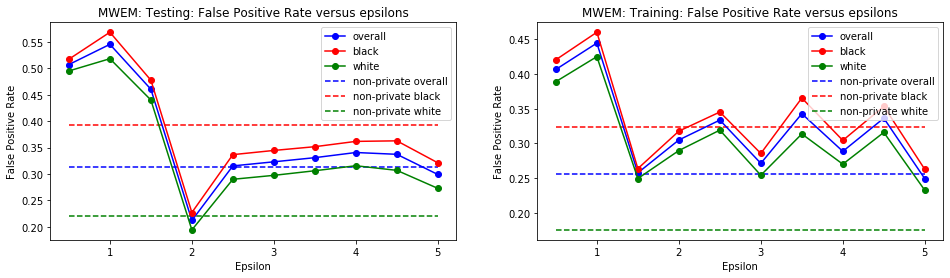

In [14]:
plotFPR("MWEM", test_results, train_results, epsilons)

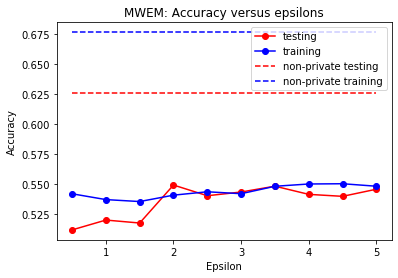

In [16]:
plotAccuracy("MWEM", test_results, train_results, epsilons)

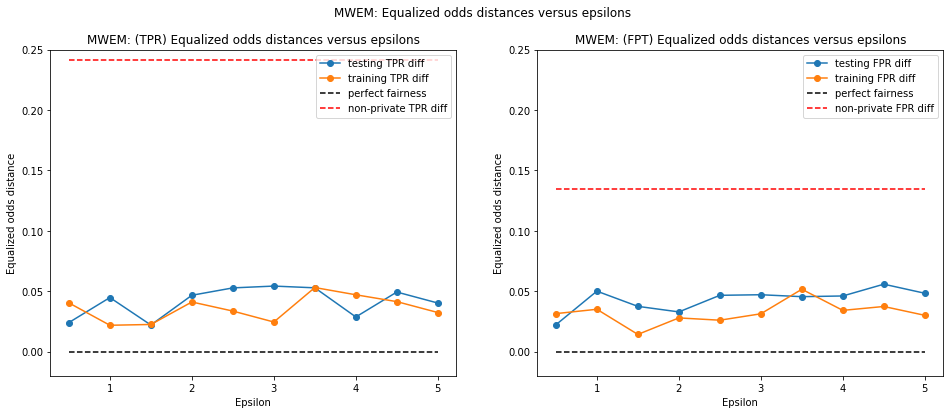

In [18]:
plotEqualizedOdds("MWEM", test_results, train_results, epsilons)


Calculate the ratios of people who recidivated and the ratio of African-American people in the total population.

In [87]:
print((df['two_year_recid']==1).sum()/df.shape[0])
print((df['race']==1).sum()/df.shape[0])

0.47044334975369456
0.6015536187949981


Next, examine whether synthetic differential privacy(DP) dataset versus different epsilons will preserve the ratios or make a difference.

In [96]:
epsilons = np.linspace(0.5,5,10)
ratio_results = np.load("COMPAS_fairness_mwem_analysis.npy", allow_pickle=True).item()

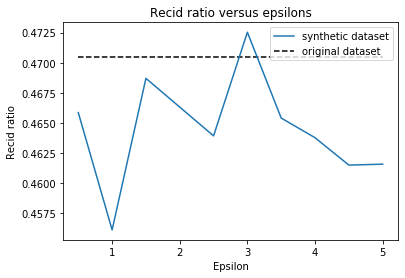

In [97]:
plotRecidRatio(epsilons, ratio_results["recid_ratio_avg"])

**Finding 1**: Recidivate ratio of synthetic DP data is align with the ratio of the original data by fluctuating around it and seem to be unrelated with the value of epsilon.

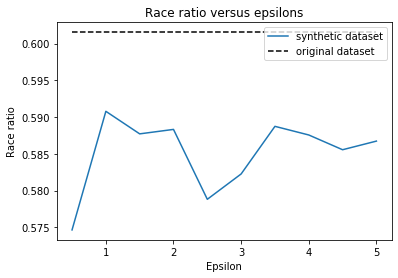

In [98]:
plotRaceRatio(epsilons, ratio_results["race_ratio_avg"])

**Finding 2:** But in terms of race ratio, synthetic data will try to lower the original one (60%) and thus make it more fair.

Next, we examine the ratios of four groups: white who did not recedivate (24.27%), white who recedivated (15.57%), black who did not recedivate (28.69%), and black who recedivated (31.47%).

Two Year Recid        0        1
Race                            
0               0.24271  0.15574
1               0.28685  0.31470


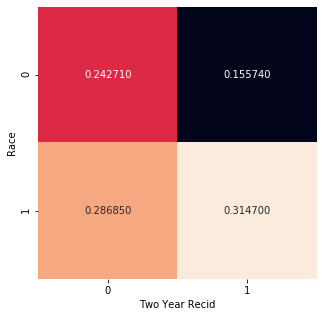

In [95]:
cm = pd.crosstab(df['race'], df['two_year_recid'], rownames=['Race'], colnames=['Two Year Recid'])
cm = round(cm/(df.shape[0]),5)
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt="f", cbar=False)
print(cm)

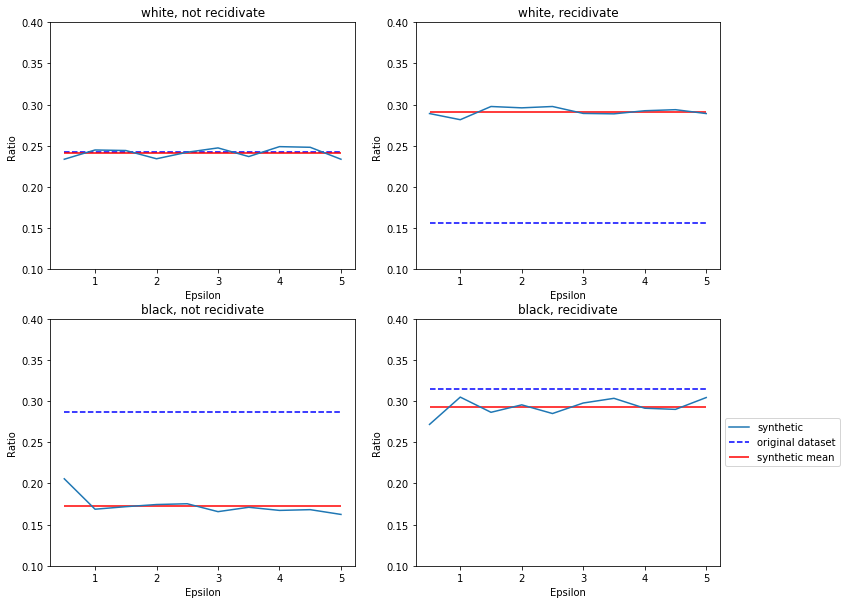

In [100]:
plotTable(epsilons, ratio_results["table00"],ratio_results["table01"],
          ratio_results["table10"],ratio_results["table11"])

The reason we suspect synthetic data is more fair is due to the fact that if a dataset has more population of one group and few of the other, the model will probably cheat by just predict that group to be 1 (recidivated in this case) and 0 to the counterpart.

## 5.3 QUAIL

In [ ]:
epsilons = list(range(1,6))
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_QUAIL.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

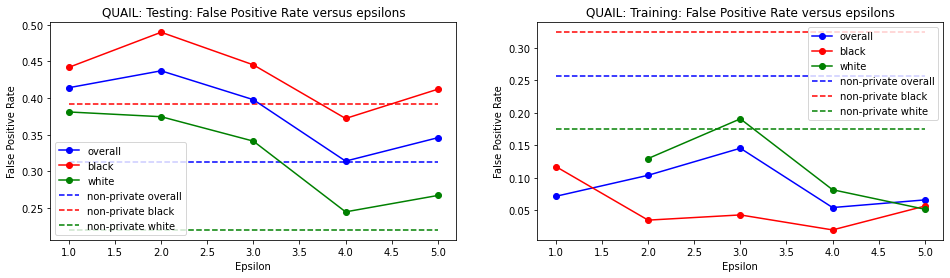

In [77]:
plotFPR("QUAIL", test_results, train_results, epsilons)

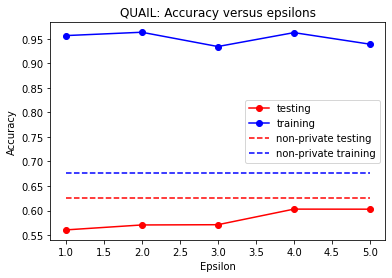

In [78]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

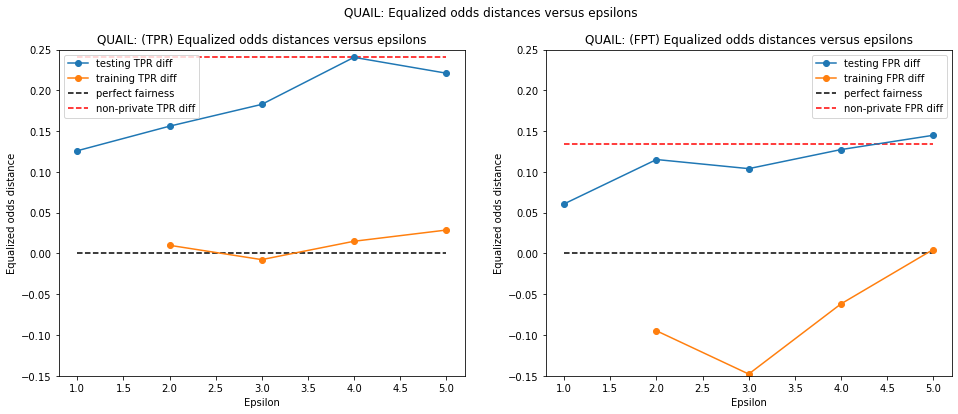

In [80]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons, [-0.15,0.25])


In [ ]:
# with 0.5 per iteration
epsilons = list(np.arange(1,6,0.5))

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL_2.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_QUAIL_2.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

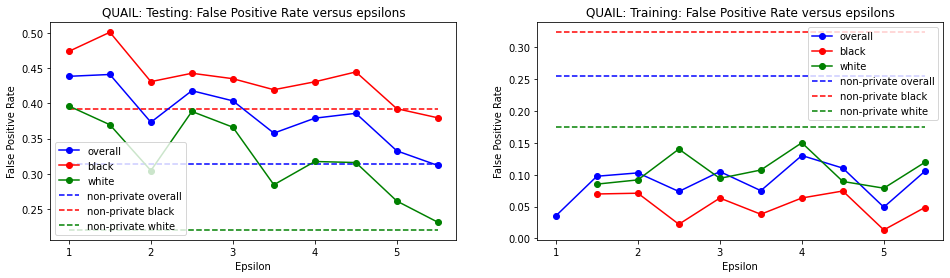

In [82]:
plotFPR("QUAIL", test_results, train_results, epsilons)

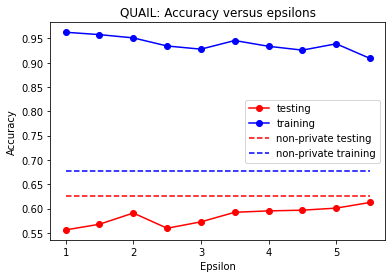

In [83]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

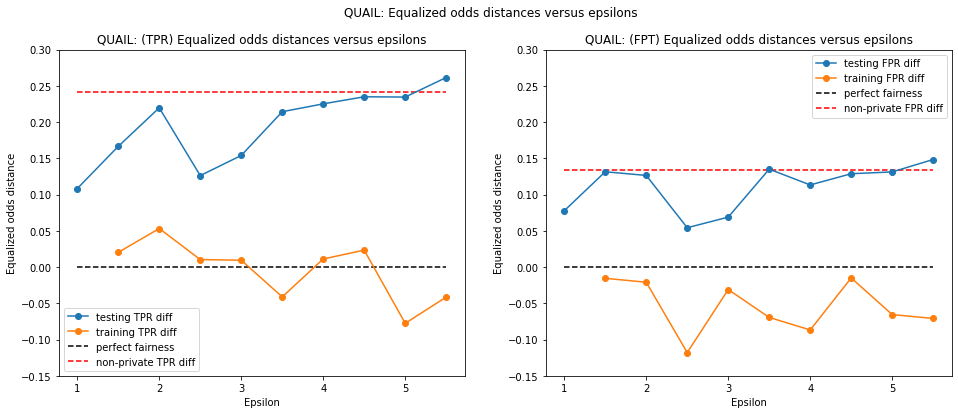

In [87]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons,[-0.15,0.30])

## 5.4 DPCTGAN

For DPCTGAN, the first GAN method we explored, we re-imported the data here because DPCTGAN is more capable of handling continous variables, so we don't bin ages into three intervals $(<25, 25-50, >50)$, unlike in MWEM and QUAIL. 

In [19]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df = process_COMPAS(df, is_GAN = True)

In [20]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=random.randint(0,100))

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

In [21]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_DPCTGAN = np.load("COMPAS_fairness_DPCTGAN.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_DPCTGAN["train_results"], COMPAS_fairness_DPCTGAN["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="DPCTGAN")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_DPCTGAN.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

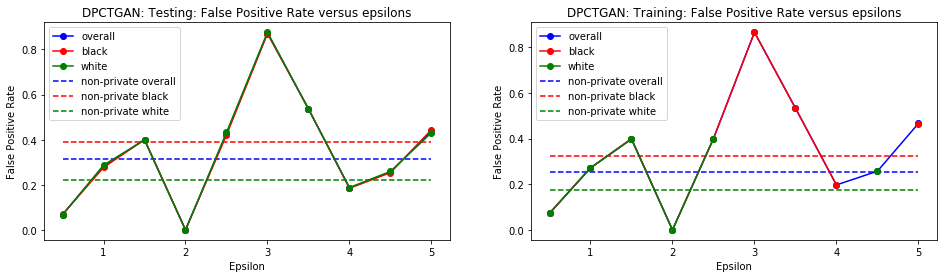

In [22]:
plotFPR("DPCTGAN", test_results, train_results, epsilons)

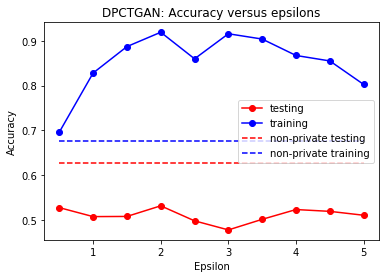

In [23]:
plotAccuracy("DPCTGAN", test_results, train_results, epsilons)

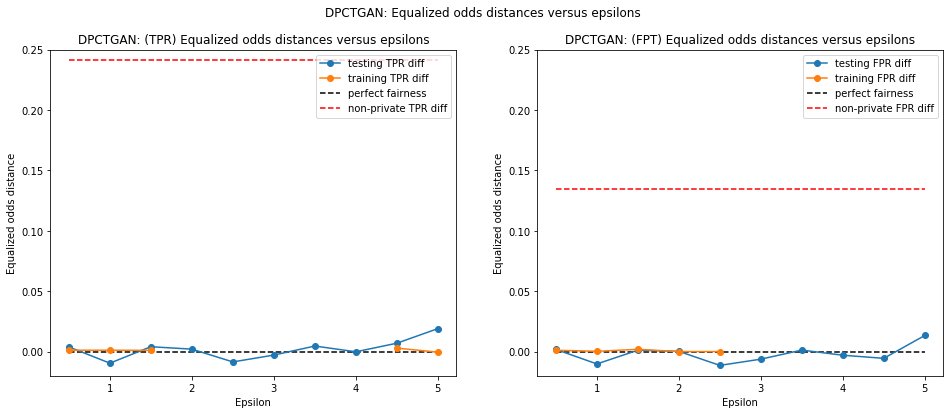

In [24]:
plotEqualizedOdds("DPCTGAN", test_results, train_results, epsilons,[-0.02,0.25])

Since we observe overfitting, we are curious to know if the accuracy is also low for synthetic testing data.

In [43]:
def average(all_results):
    nepsilons = len(all_results)
    niteration = len(all_results[0])
    avg_results = []
    for e in range(nepsilons): 
        overall, black, white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        for i in range(niteration):
            curr_overall, curr_black, curr_white = all_results[e][i][0],all_results[e][i][1],all_results[e][i][2]
            overall = [rate1+rate2 for rate1,rate2 in zip(overall,curr_overall)]
            white = [rate1+rate2 for rate1,rate2 in zip(white,curr_white)]
            black = [rate1+rate2 for rate1,rate2 in zip(black,curr_black)]
        
        overall = [rate/niteration for rate in overall]
        black = [rate/niteration for rate in black]
        white = [rate/niteration for rate in white]
        
        avg_results.append([overall,black,white])
    return avg_results

In [ ]:
def load(results_dict):
    train_results = results_dict["avg_results"]["train_results"] 
    test_results = results_dict["avg_results"]["test_results"]
    test_synth_results = results_dict["avg_results"]["test_synth_results"]
    train_all_results = results_dict["all_results"]["train_all_results"]
    test_all_results = results_dict["all_results"]["test_all_results"]
    test_synth_all_results = results_dict["all_results"]["test_synth_all_results"]
    ratio_results = results_dict["ratio_results"]
    return train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results 

In [101]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("COMPAS_fairness_DPCTGAN_all_results.npy", allow_pickle=True).item()
    
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer = "DPCTGAN", all_results = True)
    # calculate average result for synthetic test data
    results_dict["avg_results"]["test_synth_results"] = average(results_dict["all_results"]["test_synth_all_results"])
    np.save("COMPAS_fairness_DPCTGAN_all_results.npy", results_dict)

train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results = load(results_dict)

0.5: 0, Epoch 1, Loss G: 0.6165, Loss D: 1.4067
epsilon is 0.4331707546028254, alpha is 37.0

1.0: 0, Epoch 1, Loss G: 0.6940, Loss D: 1.4047
epsilon is 0.4331707546028254, alpha is 37.0
Epoch 2, Loss G: 0.6893, Loss D: 1.3992
epsilon is 0.5991567933620532, alpha is 28.0
Epoch 3, Loss G: 0.6857, Loss D: 1.3917
epsilon is 0.7276666888717819, alpha is 23.0
Epoch 4, Loss G: 0.6874, Loss D: 1.3874
epsilon is 0.8370973504506423, alpha is 21.0
Epoch 5, Loss G: 0.6916, Loss D: 1.3768
epsilon is 0.933795026976014, alpha is 19.0



in


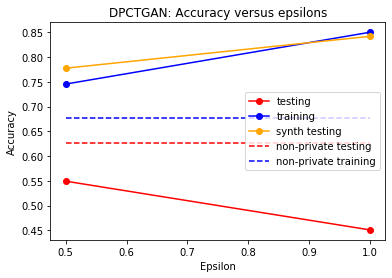

In [102]:
plotAccuracy("DPCTGAN", test_results, train_results, epsilons, test_synth_results)

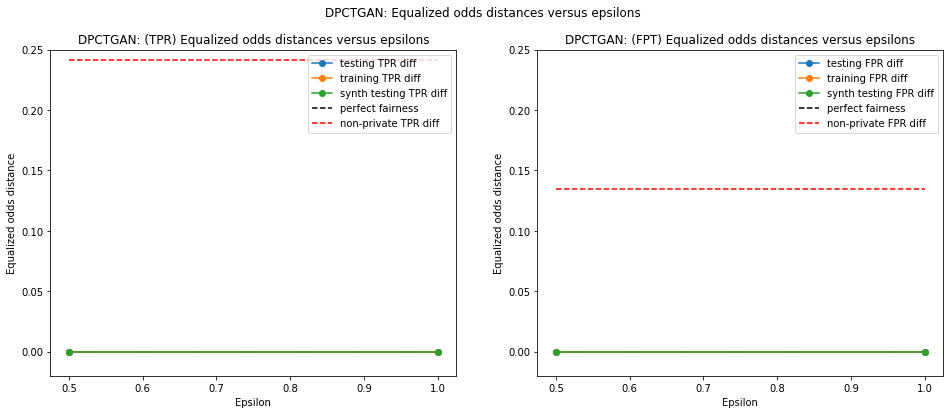

In [103]:
plotEqualizedOdds("DPCTGAN", test_results, train_results, epsilons, (-0.02,0.25), test_synth_results)

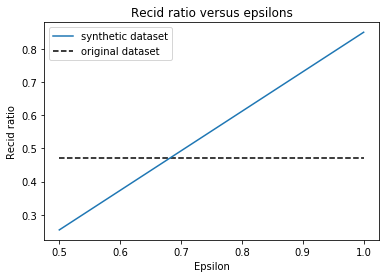

In [104]:
plotRecidRatio(epsilons, ratio_results["recid_ratio_avg"])

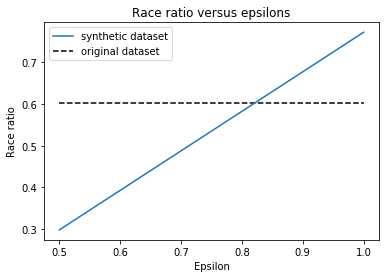

In [105]:
plotRaceRatio(epsilons, ratio_results["race_ratio_avg"])

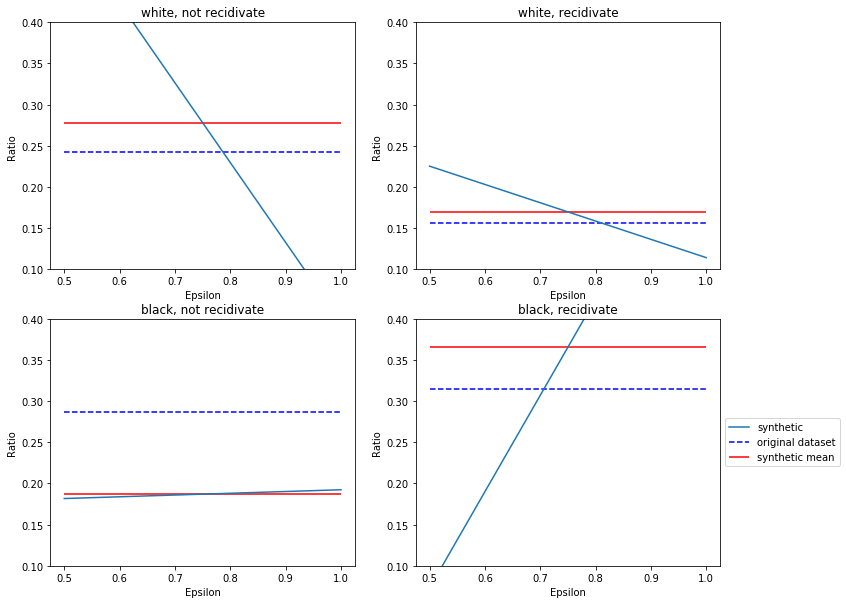

In [106]:
plotTable(epsilons, ratio_results["table00"],ratio_results["table01"],
          ratio_results["table10"],ratio_results["table11"])

## 5.5 PATECTGAN

In [25]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_PATECTGAN = np.load("COMPAS_fairness_PATECTGAN.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_PATECTGAN["train_results"], COMPAS_fairness_PATECTGAN["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="PATECTGAN")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_PATECTGAN.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

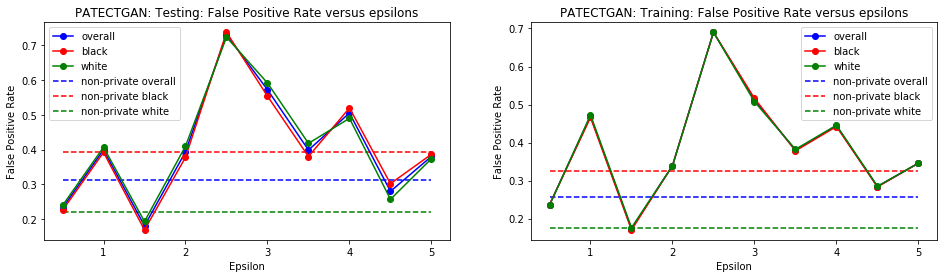

In [26]:
plotFPR("PATECTGAN", test_results, train_results, epsilons)

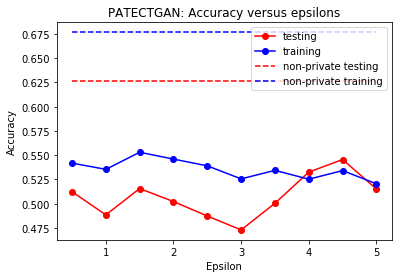

In [27]:
plotAccuracy("PATECTGAN", test_results, train_results, epsilons)

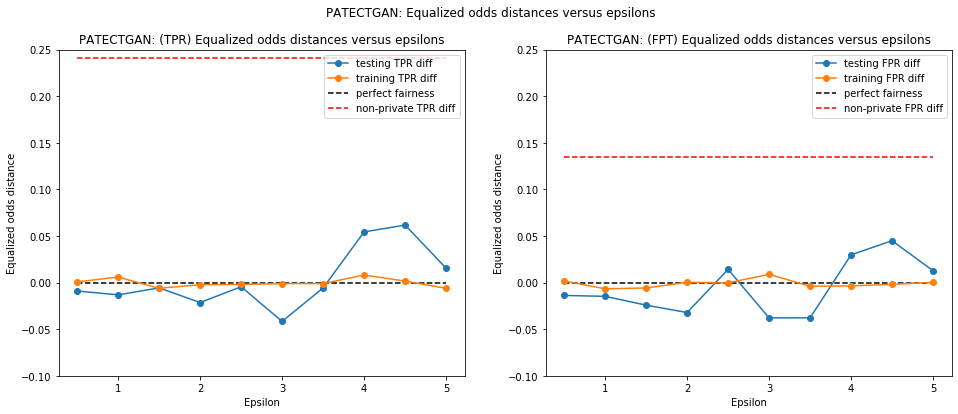

In [29]:
plotEqualizedOdds("PATECTGAN", test_results, train_results, epsilons, ylim=(-0.10,0.25))

In [ ]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("COMPAS_fairness_PATECTGAN_all_results.npy", allow_pickle=True).item()
    
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer = "PATECTGAN", all_results = True)
    results_dict["avg_results"]["test_synth_results"] = average(results_dict["all_results"]["test_synth_all_results"])
    np.save("COMPAS_fairness_PATECTGAN_all_results.npy", results_dict)
    
train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results = load(results_dict)


## 5.6 DPCTGAN + QUAIL